In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
from slsim.image_simulation import lens_image_series
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.image_simulation import point_source_coordinate_properties
from slsim import lsst_science_pipeline
import matplotlib.pyplot as plt
import corner
import astropy.coordinates as coord
import astropy.units as u

## Supernovae plus extended source simulation
In this notebook, we simulate population of lensed supernovae and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the "scotch_SNIa_host_galaxies.fits"

file from the following link: https://github.com/LSST-strong-lensing/data_public.git. 

This file contains type Ia supernovae host galaxies.

## Simulate lensed supernovae population

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the
# skypy config
# file)
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {}
## create a point plus extended source lens population.
supernova_lens_pop = LensPop(
    deflector_type="elliptical",  # type of the deflector. It could be elliptical or
    # all-galaxies.
    source_type="supernovae_plus_galaxies",  # keyword for source type. it can be
    # galaxies, quasar, quasar_plus_galaxies, and supernovae_plus_galaxies.
    kwargs_deflector_cut=kwargs_deflector_cut,  # cuts that one wants to apply for the
    # deflector.
    kwargs_source_cut=kwargs_source_cut,  # cuts that one wants to apply for the
    # source.
    variability_model="light_curve",  # keyword for the variability model.
    kwargs_variability={"supernovae_lightcurve", "i"},  # specify kewords for
    # lightcurve. "i" is a band for the lightcurve.
    sn_type="Ia",  # supernovae type.
    sn_absolute_mag_band="bessellb",  # Band used to normalize to absolute magnitude
    sn_absolute_zpsys="ab",  # magnitude system. It can be Optional, AB or Vega.
    kwargs_mass2light=None,  # mass-to-light relation for the deflector galaxy.
    skypy_config=None,  # Sky configuration for the simulation. If None, lsst-like
    # configuration will be used.
    sky_area=sky_area,  # Sky area for the simulation, source / deflector sky area
    cosmo=cosmo,  # astropy cosmology
    source_light_profile="double_sersic",  # light profile for the source galaxy
    catalog_type="scotch",  # catalog type. It can be None or scotch
    lightcurve_time=np.linspace(
        -20, 100, 1000
    ),  # array of light curve observation time.
    catalog_path="../data/Scotch/" + "scotch_SNIa_host_galaxies.fits",
    # path for catalog. If not provided, small size catalog from
    # /slsim/Source/SupernovaeCatalog will be used for
    # source_type="supernovae_plus_galaxies" case. For other cases, we do not need to
    # provide outside catalog. One can download scotch_SNIa_host_galaxies.fits from
    # https://github.com/LSST-strong-lensing/data_public.git
)

In [3]:
print(
    "Found",
    supernova_lens_pop.deflector_number,
    "potential lenses and",
    supernova_lens_pop.source_number,
    "potential sources.",
)

Found 7810 potential lenses and 10000 potential sources.


## Choose a random lens

In [4]:
# specifying cuts of the population
kwargs_lens_cuts = {}
# drawing population
supernovae_lens_population = supernova_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts  # speed_factor=200
)

In [5]:
print("Number of strong lens systems:", len(supernovae_lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm host}$",
    r"$m_{\rm ps}$",
    r"$m_{\rm lens}$",
]

for supernovae_lens in supernovae_lens_population:
    vel_disp = supernovae_lens.deflector_velocity_dispersion()
    m_star = supernovae_lens.deflector_stellar_mass()
    theta_e = supernovae_lens.einstein_radius
    zl = supernovae_lens.deflector_redshift
    zs = supernovae_lens.source_redshift
    source_mag = supernovae_lens.extended_source_magnitude(band="i", lensed=True)
    ps_source_mag = supernovae_lens.point_source_magnitude(band="i")
    deflector_mag = supernovae_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [
            vel_disp,
            np.log10(m_star),
            theta_e,
            zl,
            source_mag,
            ps_source_mag,
            deflector_mag,
        ]
    )

Number of strong lens systems: 17


/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/slsim/Sources/source.py:362: RuntimeWarning: divide by zero encountered in log10
  mag_source0 = -2.5 * np.log10(w0 * flux)
/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


## Choose a lens to simulate an image

In [6]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = supernovae_lens_population[2]
(
    lens_class.source.source_dict["z"],
    lens_class.einstein_radius,
    lens_class.source.source_dict["mag_i"],
    lens_class.source.source_dict["ps_mag_i"],
    # lens_class._deflector_dict["mag_i"],
    # lens_class._deflector_dict["z"],
)

(1.832039, 0.5321404664052483, 24.688736, 26.831420679814215)

In [7]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=32,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

In [8]:
pix_coord

array([[11.52138022, 14.5660759 ],
       [15.49632453, 16.44243526]])

## See the light curve of a selected supernovae

In [9]:
light_curve = lens_class.source.variability_class.kwargs_model

print("This is a type", lens_class.source.sn_type, "SN")

This is a type Ia SN


(-22.0, 100.0)

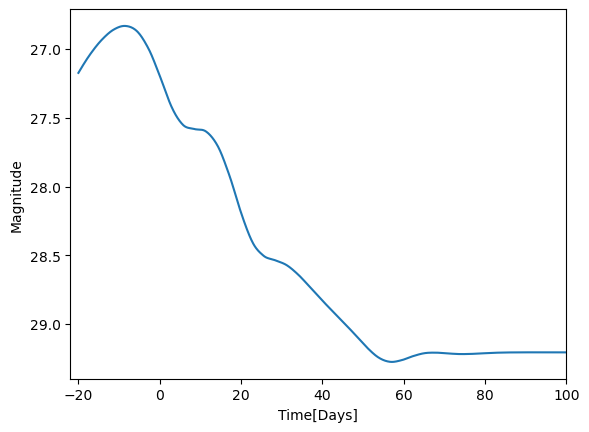

In [10]:
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"])
# plt.ylim(12, 18)
plt.gca().invert_yaxis()
plt.ylabel("Magnitude")
plt.xlabel("Time" "[Days]")
plt.xlim(-22, 100)

## Get observation properties from OpSim

Generate random points on the sky

In [11]:
N = 10

ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180 * u.degree)
dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180
dec_points = coord.Angle(dec_points * u.degree)

In [ ]:
exposure_data = lsst_science_pipeline.opsim_time_series_images_data(
    ra_points, dec_points, "baseline_v3.0_10yrs", MJD_min=60000, MJD_max=60300
)
exposure_data

In [ ]:
index = 0
bands = ["g", "r", "i", "z"]
num_pix = 200
transform_pix2angle = np.array([[0.2, 0], [0, 0.2]])

images = opsim_variable_lens_injection(
    lens_class, bands, num_pix, transform_pix2angle, exposure_data[index]
)
images

## Set observation time and image configuration

In [ ]:
time = np.array([-19.5, -15, -11.35135135135135, 0, 10, 20, 25, 30, 40, 44.86])
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = 10
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

## Simulate Image

In [ ]:
# Simulate a lens image
image_lens_series = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=32,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

# Make opsim_lens_image_series function (main difference: bands [list] instead of band [number])
# Also make a function to plot light curve with observations

In [ ]:
## Images in log scale
log_images = []
for i in range(len(image_lens_series)):
    log_images.append(np.log10(image_lens_series[i]))

## Visualize simulated images

In [ ]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=image_lens_series, time=time, image_center=pix_coord
)

# add "band=band" and add as text to plots

### Notes

- Can I make a separate function to calculate the zero point?

- calexp_center just contains the object coordinates so is currently a lot of duplicates for each epoch. Maybe there's a more efficient way to save it (or maybe it doesn't matter). 

- 'injected_lens' now contains the same as 'lens', because there is no background image

- if catalog_type=None instead of "scotch", something goes wrong with the column names. I get the error: ellipticity or semi-major and semi-minor axis are missing for the first light profile in galaxy_list columns.
- Light curve looks a bit strange for a type Ia SN?